c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running grid: 12 configs × 3 seeds = 36 runs
cfg d=0.5, s=0.1, wd=0.0005, h=64 -> mean test 0.8073 ± 0.0058
cfg d=0.5, s=0.1, wd=0.005, h=64 -> mean test 0.8207 ± 0.0034
cfg d=0.5, s=0.2, wd=0.0005, h=64 -> mean test 0.8107 ± 0.0021
cfg d=0.5, s=0.2, wd=0.005, h=64 -> mean test 0.8200 ± 0.0024
cfg d=0.7, s=0.1, wd=0.0005, h=64 -> mean test 0.8147 ± 0.0062
cfg d=0.7, s=0.1, wd=0.005, h=64 -> mean test 0.8193 ± 0.0012
cfg d=0.7, s=0.2, wd=0.0005, h=64 -> mean test 0.8133 ± 0.0033
cfg d=0.7, s=0.2, wd=0.005, h=64 -> mean test 0.8177 ± 0.0042
cfg d=0.9, s=0.1, wd=0.0005, h=64 -> mean test 0.8200 ± 0.0014
cfg d=0.9, s=0.1, wd=0.005, h=64 -> mean test 0.8210 ± 0.0073
cfg d=0.9, s=0.2, wd=0.0005, h=64 -> mean test 0.8177 ± 0.0037
cfg d=0.9, s=0.2, wd=0.005, h=64 -> mean test 0.8197 ± 0.0061

Saved detailed runs to reg_sweep_cora_runs.csv
Saved summary to reg_sweep_summary.csv

=== Top configs (by mean test acc) ===
   dropout  label_smoothing  weight_decay  hidden  mean_test  std_test  n_runs

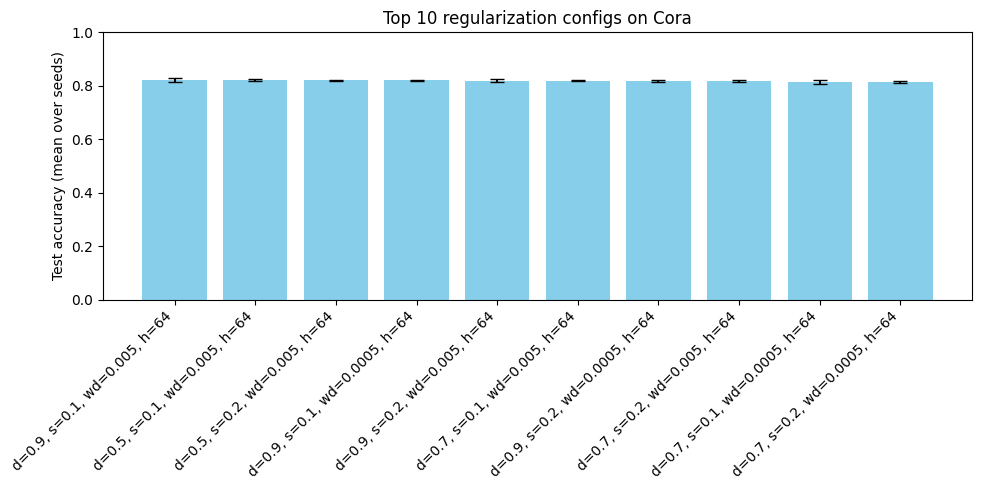

Saved plot to reg_sweep_top10.png


In [1]:
# reg_sweep_cora.py
import os
import itertools
import random
import time
import csv
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# ----------------------------
# Model: simple 2-layer GCN
# ----------------------------
class GCN(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch)
        self.conv2 = GCNConv(hid_ch, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # raw logits

# ----------------------------
# Utilities
# ----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# ----------------------------
# Train one run
# ----------------------------
def train_one_run(dataset_name="Cora",
                  hidden=64,
                  dropout=0.5,
                  weight_decay=5e-4,
                  label_smoothing=0.0,
                  lr=0.01,
                  max_epochs=300,
                  patience=50,
                  seed=0,
                  device=None,
                  verbose=False):

    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    dataset = Planetoid(root=os.path.join("data", dataset_name), name=dataset_name)
    data = dataset[0].to(device)

    model = GCN(dataset.num_node_features, hidden, dataset.num_classes, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val = -1.0
    best_test = 0.0
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            out_eval = model(data.x, data.edge_index)
            pred = out_eval.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
            test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and epoch % 50 == 0:
            print(f"Seed {seed} | epoch {epoch} | loss {loss.item():.4f} | "
                  f"val {val_acc:.4f} | test {test_acc:.4f}")

        if epochs_no_improve >= patience:
            break

    return {"best_val": best_val, "test_at_best": best_test, "best_epoch": best_epoch}

# ----------------------------
# Grid search
# ----------------------------
def run_grid_search(
    seeds=(0,1,2),
    dropout_list=(0.3, 0.5, 0.7),
    label_smooth_list=(0.0, 0.1, 0.2),
    weight_decay_list=(5e-4, 1e-3, 5e-3),
    hidden_list=(16, 64),
    dataset_name="Cora",
    max_epochs=300,
    patience=50,
    out_csv="reg_sweep_cora_results.csv",
    device=None,
    verbose=False
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    combos = list(itertools.product(dropout_list, label_smooth_list, weight_decay_list, hidden_list))
    print(f"Running grid: {len(combos)} configs × {len(seeds)} seeds = {len(combos)*len(seeds)} runs")

    # CSV header
    header = ["dropout", "label_smoothing", "weight_decay", "hidden", "seed",
              "best_val", "test_at_best", "best_epoch"]
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    summary = OrderedDict()
    for (dropout, lab_smooth, wd, hid) in combos:
        cfg_key = (dropout, lab_smooth, wd, hid)
        summary[cfg_key] = []

        for seed in seeds:
            res = train_one_run(
                dataset_name=dataset_name,
                hidden=hid,
                dropout=dropout,
                weight_decay=wd,
                label_smoothing=lab_smooth,
                lr=0.01,
                max_epochs=max_epochs,
                patience=patience,
                seed=seed,
                device=device,
                verbose=verbose
            )
            with open(out_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([dropout, lab_smooth, wd, hid, seed,
                                 f"{res['best_val']:.6f}", f"{res['test_at_best']:.6f}",
                                 res["best_epoch"]])
            summary[cfg_key].append(res["test_at_best"])

        arr = np.array(summary[cfg_key])
        mean, std = arr.mean(), arr.std()
        print(f"cfg d={dropout}, s={lab_smooth}, wd={wd}, h={hid} -> mean test {mean:.4f} ± {std:.4f}")

    rows = []
    for k, vals in summary.items():
        dropout, lab_smooth, wd, hid = k
        arr = np.array(vals)
        rows.append({
            "dropout": dropout,
            "label_smoothing": lab_smooth,
            "weight_decay": wd,
            "hidden": hid,
            "mean_test": arr.mean(),
            "std_test": arr.std(),
            "n_runs": len(arr)
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("mean_test", ascending=False).reset_index(drop=True)
    df.to_csv("reg_sweep_summary.csv", index=False)
    print("\nSaved detailed runs to", out_csv)
    print("Saved summary to reg_sweep_summary.csv")
    return df

# ----------------------------
# Plot helper
# ----------------------------
def plot_topk(df, k=10, save_png="reg_sweep_topk.png"):
    topk = df.head(k)
    labels = []
    means = topk["mean_test"].values
    stds = topk["std_test"].values
    for _, row in topk.iterrows():
        labels.append(f"d={row['dropout']}, s={row['label_smoothing']}, "
                      f"wd={row['weight_decay']}, h={int(row['hidden'])}")
    plt.figure(figsize=(10,5))
    x = np.arange(len(labels))
    plt.bar(x, means, yerr=stds, capsize=5, color="skyblue")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0,1)
    plt.ylabel("Test accuracy (mean over seeds)")
    plt.title(f"Top {k} regularization configs on Cora")
    plt.tight_layout()
    plt.savefig(save_png, dpi=200)
    plt.show()
    print("Saved plot to", save_png)

# ----------------------------
# Main entry
# ----------------------------
if __name__ == "__main__":
    seeds = (0, 1, 2)
    dropout_list = (0.5, 0.7, 0.9)
    label_smooth_list = (0.1, 0.2)
    weight_decay_list = (5e-4, 5e-3)
    hidden_list = (64,)

    df_summary = run_grid_search(
        seeds=seeds,
        dropout_list=dropout_list,
        label_smooth_list=label_smooth_list,
        weight_decay_list=weight_decay_list,
        hidden_list=hidden_list,
        dataset_name="Cora",
        max_epochs=300,
        patience=50,
        out_csv="reg_sweep_cora_runs.csv",
        verbose=False,
    )
    
    print("\n=== Top configs (by mean test acc) ===")
    print(df_summary.head(10))
    plot_topk(df_summary, k=10, save_png="reg_sweep_top10.png")
